<a href="https://colab.research.google.com/github/maxi2321/MAXIABDALA/blob/main/series_temporales_maxi/trabajo_final/codigo/final7.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# LECTURA DE DATOS

In [ ]:

os.chdir('/Users/maxiabdala/Documents/Python/repositorio Maxi/series_temporales_maxi/trabajo_final/codigo')

In [ ]:
# vemos los archivos de audio
data_folder = os.path.join('data', 'train')  # carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
b=0
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            duracion = librosa.get_duration(y=audio, sr=sr)
            if (b):
              if (duracion<men): men=duracion
            else:
              men=duracion
              b=1
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase auto tiene 18 elementos
La clase moto tiene 10 elementos
La clase camioneta tiene 13 elementos
La clase colectivo tiene 13 elementos


## ESPECTOGRAMAS CON STFT

Clase auto: 18 espectrogramas STFT
Clase moto: 10 espectrogramas STFT
Clase camioneta: 13 espectrogramas STFT
Clase colectivo: 13 espectrogramas STFT


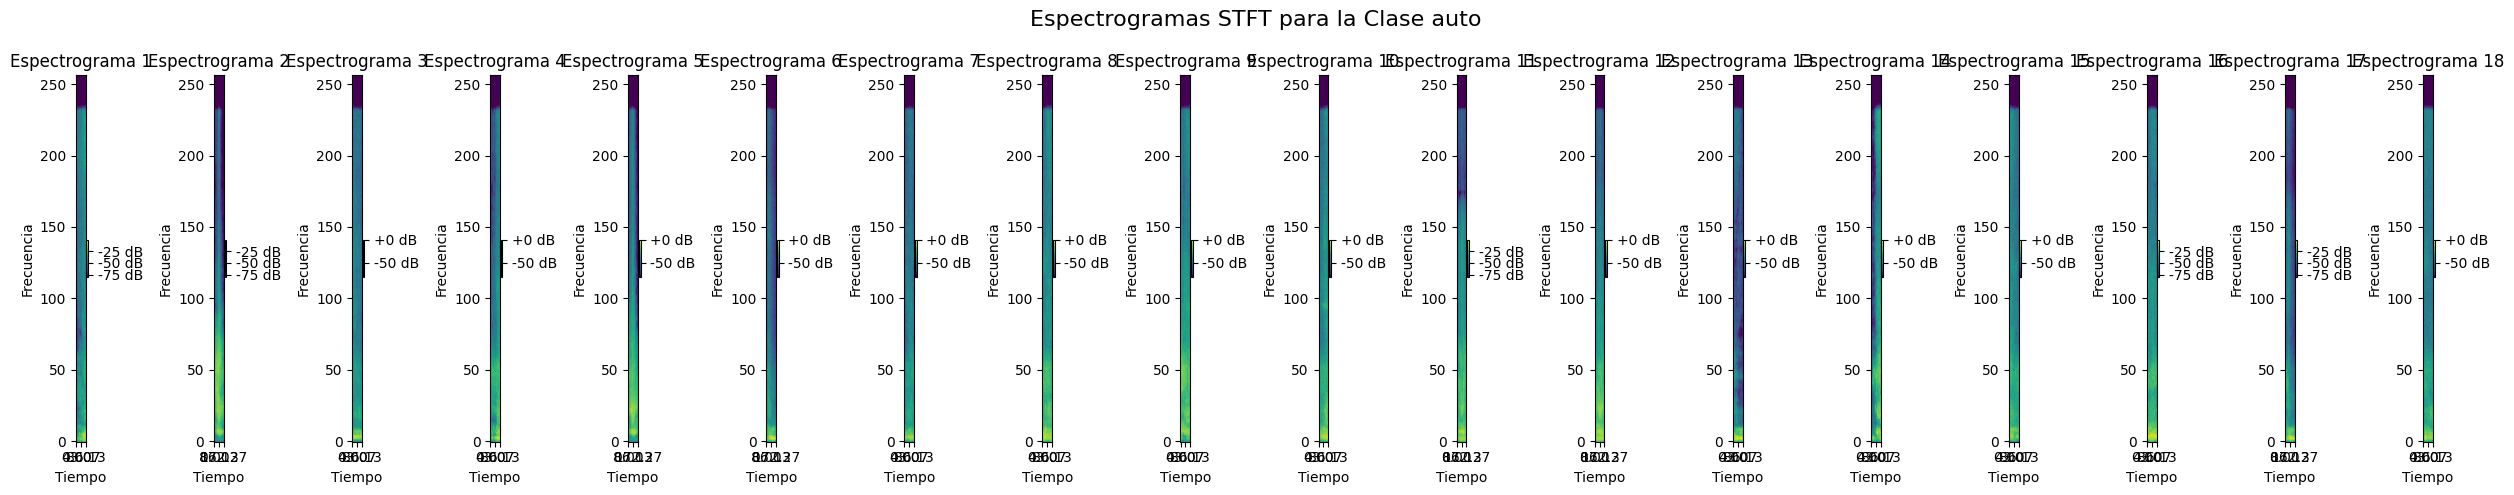

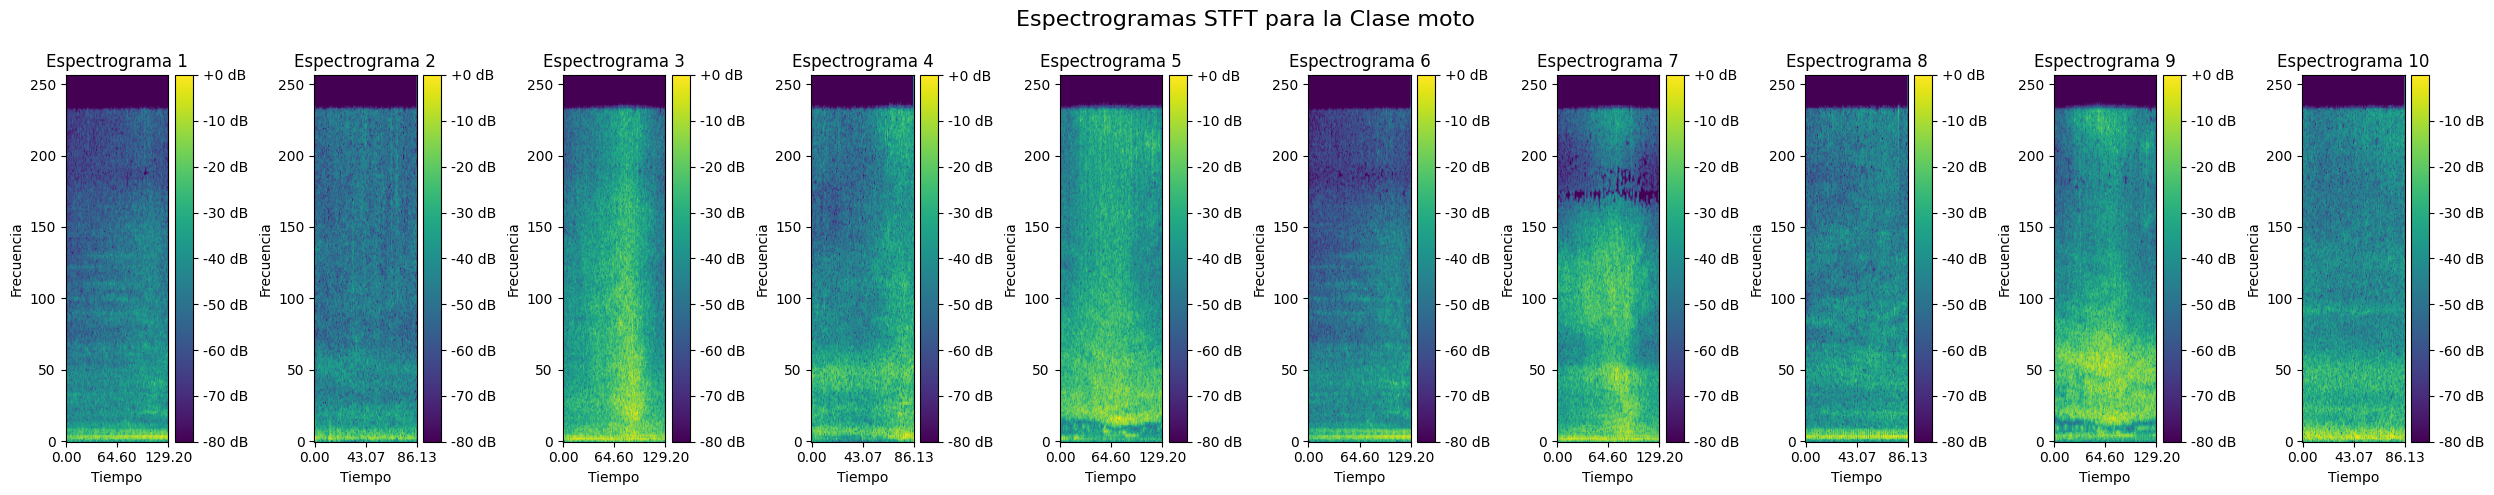

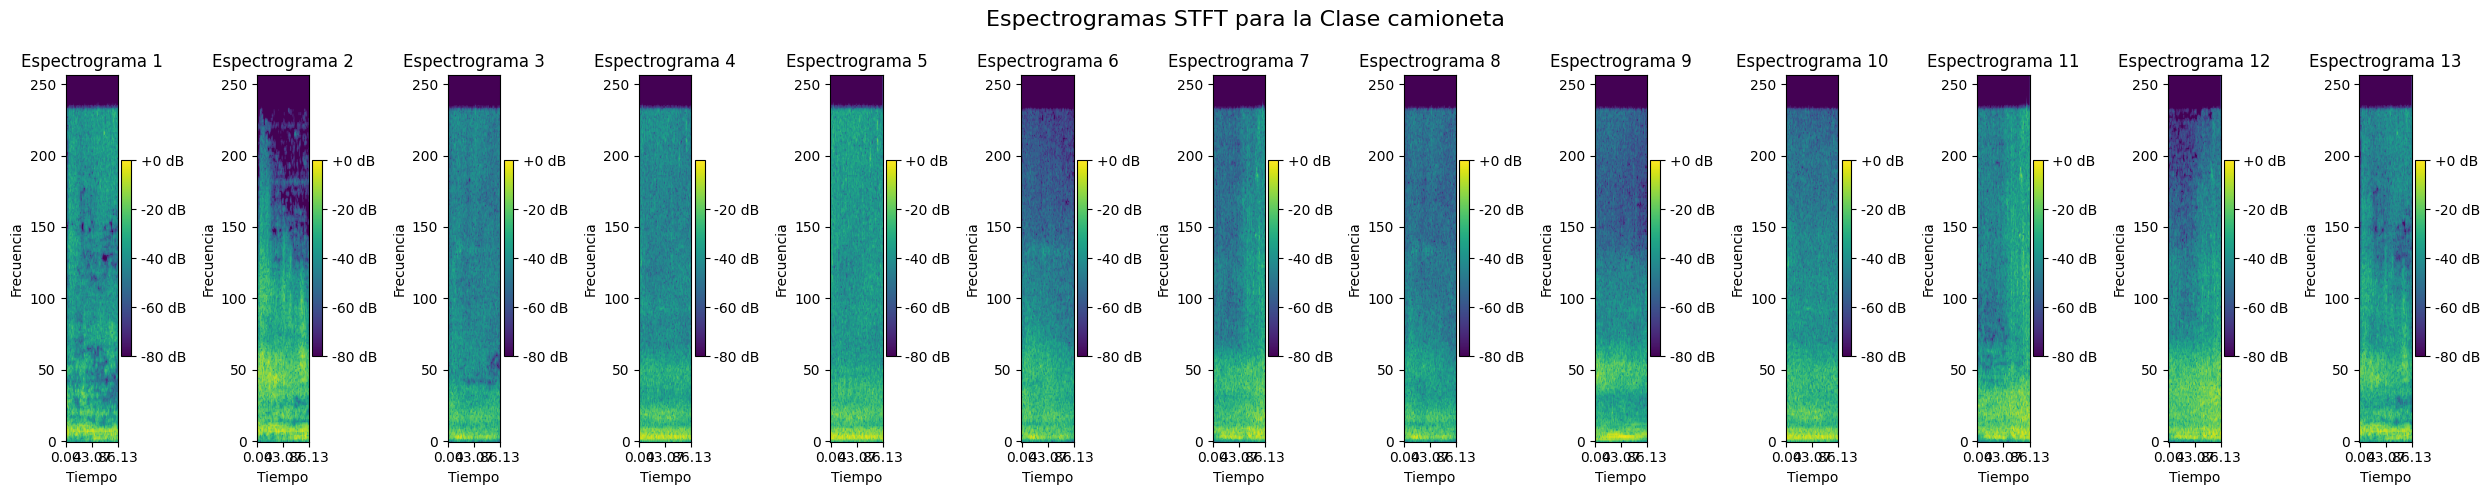

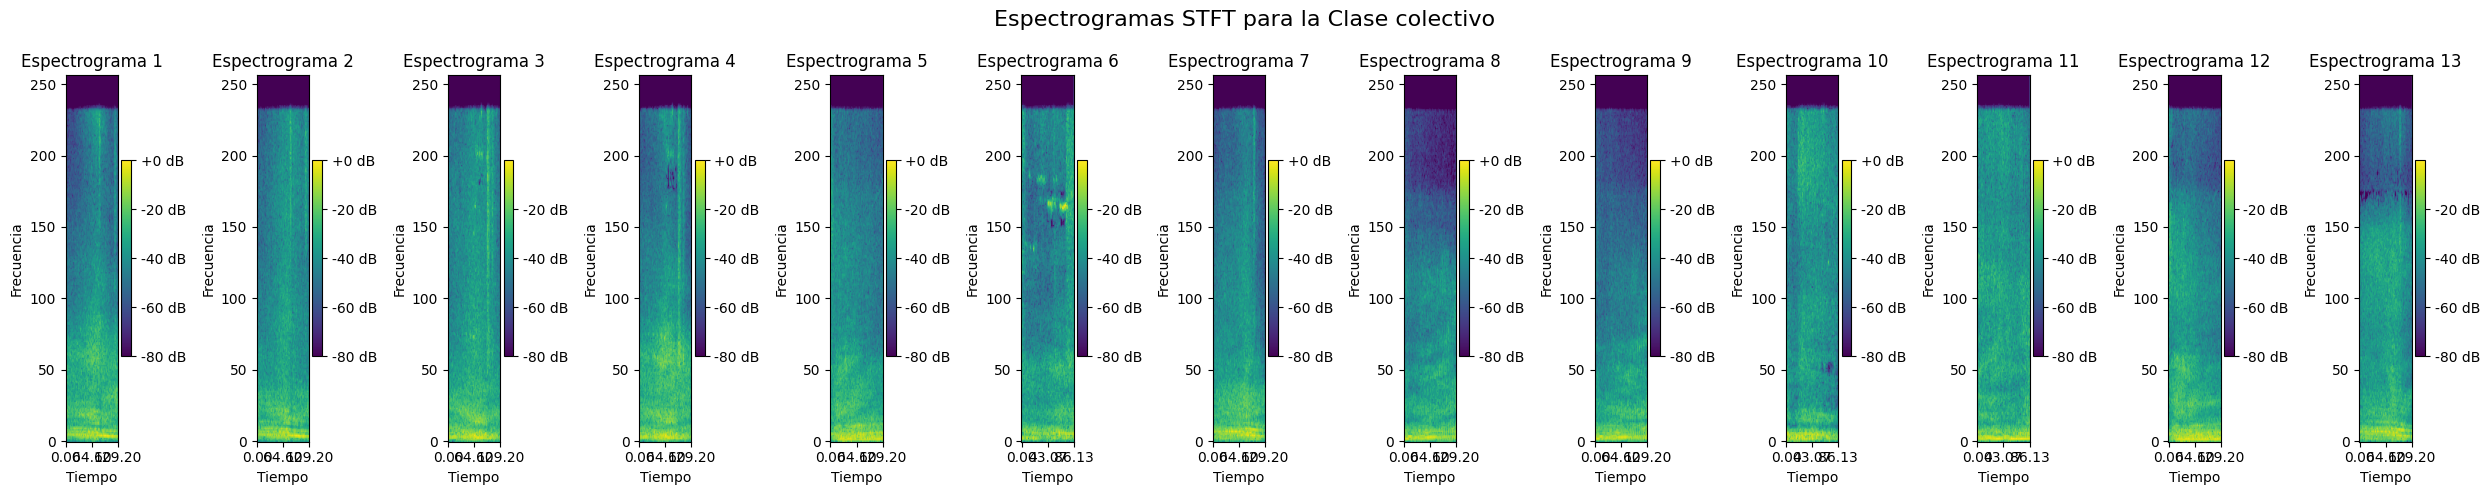

In [ ]:

# Tasa de muestreo que vamos a asumir para todos los audios
sampling_rate = 512

def compute_stft_spectrogram(audio_array, sampling_rate):
    """
    Compute STFT Spectrogram for a given audio array.

    Args:
    - audio_array (np.ndarray): Array containing audio data.
    - sr (int): Sampling rate of the audio file.

    Returns:
    - S_DB (np.ndarray): STFT spectrogram in decibels.
    """
    S = librosa.stft(y=audio_array, n_fft=sampling_rate, hop_length=400, window='hann')# probar con 'hann' o 'hamming'
    S_DB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    return S_DB

# Diccionario para almacenar los espectrogramas STFT
stft_spectrograms = {}

# Calcular los espectrogramas STFT para cada clase y cada archivo de audio
for k, v in data.items():
    stft_spectrograms[k] = []
    for audio_array in v:
        stft_spec = compute_stft_spectrogram(audio_array, sampling_rate)
        stft_spectrograms[k].append(stft_spec)

# Verificar la cantidad de espectrogramas calculados por clase
for k, v in stft_spectrograms.items():
    print(f'Clase {k}: {len(v)} espectrogramas STFT')

# Función para graficar los espectrogramas STFT de una clase específica
def plot_stft_spectrograms(stft_spectrograms, class_name, sr):
    num_specs = len(stft_spectrograms[class_name])
    fig, axs = plt.subplots(1, num_specs, figsize=(25, 5))
    fig.suptitle(f'Espectrogramas STFT para la Clase {class_name}', fontsize=16)

    for i, stft_spec in enumerate(stft_spectrograms[class_name]):
        img = axs[i].imshow(stft_spec, cmap='viridis', origin='lower', aspect='auto')
        axs[i].set_title(f'Espectrograma {i + 1}')
        axs[i].set_xlabel('Tiempo')
        axs[i].set_ylabel('Frecuencia')

        # Calcular marcas de tiempo
        num_time_bins = stft_spec.shape[1]
        duration = len(data[class_name][i]) / sr
        time_ticks = np.linspace(0, duration, num_time_bins)

        # Configurar las marcas de tiempo en el eje x
        axs[i].set_xticks(np.linspace(0, num_time_bins, 3))
        axs[i].set_xticklabels([f'{t:.2f}' for t in np.linspace(0, duration, 3)])

        fig.colorbar(img, ax=axs[i], format='%+2.0f dB')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustar el espacio para el título
    plt.show()

# Graficar los espectrogramas STFT para cada clase
for class_name in stft_spectrograms.keys():
    plot_stft_spectrograms(stft_spectrograms, class_name, sampling_rate)


In [ ]:
len(stft_spectrograms['auto'][1])

257

# PASAMOS LOS ESPECTOGRAMAS A TENSORES PARA ARMAR EL DATASET

In [ ]:
# 'men' contiene 'tiempo' que queremos de los espectrogramas
men = 130 # Ajusta la longitud esta en centisegunos creo... hay que revisar

# Convertir los espectrogramas de Mel a tensores de PyTorch
mel_tensor_list = []
labels_list = []

# Iterar sobre las clases y los espectrogramas de Mel correspondientes
for label, mel_specs in stft_spectrograms.items():
    for mel_spec in mel_specs:
        # Asegurarse de que todos los espectrogramas tengan la misma forma (128, men)
        if mel_spec.shape[1] > men:
            mel_spec = mel_spec[:, :men]  # Recortar si es más largo
        elif mel_spec.shape[1] < men:
            mel_spec = np.pad(mel_spec, ((0, 0), (0, men - mel_spec.shape[1])), mode='constant')  # Rellenar si es más corto

        mel_tensor = torch.tensor(mel_spec).unsqueeze(0).float()  # Convertir y añadir dimensión de canal
        mel_tensor_list.append(mel_tensor)
        labels_list.append(label)

# Convertir la lista de etiquetas a tensores de PyTorch
labels_tensor = torch.tensor([list(stft_spectrograms.keys()).index(label) for label in labels_list])

# Crear un Dataset de PyTorch
dataset = TensorDataset(torch.stack(mel_tensor_list), labels_tensor)


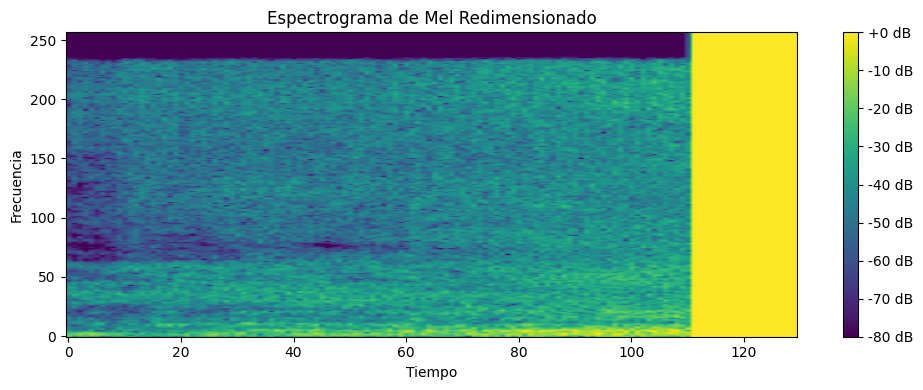

In [ ]:
# Seleccionar un espectrograma de Mel para graficar
mel_spec_to_plot = mel_tensor_list[0].squeeze().numpy()  # Convertir de tensor a numpy y eliminar la dimensión del canal

# Graficar el espectrograma de Mel
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_to_plot, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Mel Redimensionado')
plt.xlabel('Tiempo')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

In [ ]:
# Acceder a un solo elemento del dataset (por ejemplo, el primer elemento)
sample_image, sample_label = dataset[0]

# Inspeccionar las dimensiones del tensor de la imagen
print("Dimensiones de la imagen:", sample_image.size())

# Inspeccionar las dimensiones del tensor de etiquetas
print("Dimensiones de la etiqueta:", sample_label.size())

Dimensiones de la imagen: torch.Size([1, 257, 130])
Dimensiones de la etiqueta: torch.Size([])


## SEPARAMOS EN TRAIN Y VAL

In [ ]:
from torch.utils.data import random_split

# Definir el tamaño del conjunto de entrenamiento y validación
train_size = int(0.8 * len(dataset))  # Usaremos el 80% para entrenamiento
val_size = len(dataset) - train_size  # El restante para validación

# Dividir el dataset en conjuntos de entrenamiento y validación
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Opcionalmente, puedes imprimir el tamaño de cada conjunto para verificar
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")


Tamaño del conjunto de entrenamiento: 43
Tamaño del conjunto de validación: 11


## DATALOADERS

In [ ]:
from torch.utils.data import DataLoader

# Definir el tamaño del lote (batch size)
batch_size = 32  # Puedes ajustar este valor según la memoria disponible y el tamaño de tu dataset

# Crear DataLoader para el conjunto de entrenamiento
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Crear DataLoader para el conjunto de validación
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## MODELO

In [ ]:
# Definir una red neuronal convolucional simple


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Calcular el tamaño de entrada para la capa fully connected
        self.fc1 = nn.Linear(65536, 128)  # Ajustar el tamaño de entrada según el tamaño de salida calculado

        self.lstm = nn.LSTM(128, 64, batch_first=True)
        self.fc2 = nn.Linear(64, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Aplanar la salida de las capas convolucionales para la capa fully connected
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu(x)

        # Agregar la dimensión de tiempo para la entrada a la capa LSTM
        x = x.unsqueeze(1)

        lstm_out, _ = self.lstm(x)
        x = lstm_out[:, -1, :]  # Tomar solo la última salida de la secuencia LSTM

        x = self.fc2(x)
        x = self.softmax(x)

        return x

## INSTANCIAMOS EL MODELO

In [ ]:
# Definir hiperparámetros
learning_rate = 0.0001
num_epochs = 10000

# Crear una instancia del modelo
model = SimpleCNN(num_classes=4)  # Ajusta num_classes según el número de clases en tu dataset

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## FUNCION DE ENTRENAMIENTO

In [ ]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Modo de entrenamiento
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Modo de evaluación
        model.eval()
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_accuracy = correct_preds / total_preds
        val_accuracies.append(val_accuracy)

        # Imprimir métricas del epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Graficar las curvas de pérdida y precisión en validación
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(np.arange(1, num_epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## ENTRENAMIENTO

Epoch [1/10000], Train Loss: 1.3804, Val Loss: 1.4031, Val Acc: 0.0909
Epoch [2/10000], Train Loss: 1.3778, Val Loss: 1.3923, Val Acc: 0.1818
Epoch [3/10000], Train Loss: 1.3784, Val Loss: 1.3883, Val Acc: 0.3636
Epoch [4/10000], Train Loss: 1.3745, Val Loss: 1.3832, Val Acc: 0.3636
Epoch [5/10000], Train Loss: 1.3687, Val Loss: 1.3825, Val Acc: 0.3636
Epoch [6/10000], Train Loss: 1.3671, Val Loss: 1.3862, Val Acc: 0.1818
Epoch [7/10000], Train Loss: 1.3653, Val Loss: 1.3884, Val Acc: 0.1818
Epoch [8/10000], Train Loss: 1.3648, Val Loss: 1.3734, Val Acc: 0.3636
Epoch [9/10000], Train Loss: 1.3593, Val Loss: 1.3641, Val Acc: 0.3636
Epoch [10/10000], Train Loss: 1.3571, Val Loss: 1.3707, Val Acc: 0.3636
Epoch [11/10000], Train Loss: 1.3568, Val Loss: 1.3674, Val Acc: 0.3636
Epoch [12/10000], Train Loss: 1.3553, Val Loss: 1.3692, Val Acc: 0.3636
Epoch [13/10000], Train Loss: 1.3524, Val Loss: 1.3760, Val Acc: 0.3636
Epoch [14/10000], Train Loss: 1.3519, Val Loss: 1.3726, Val Acc: 0.1818
E

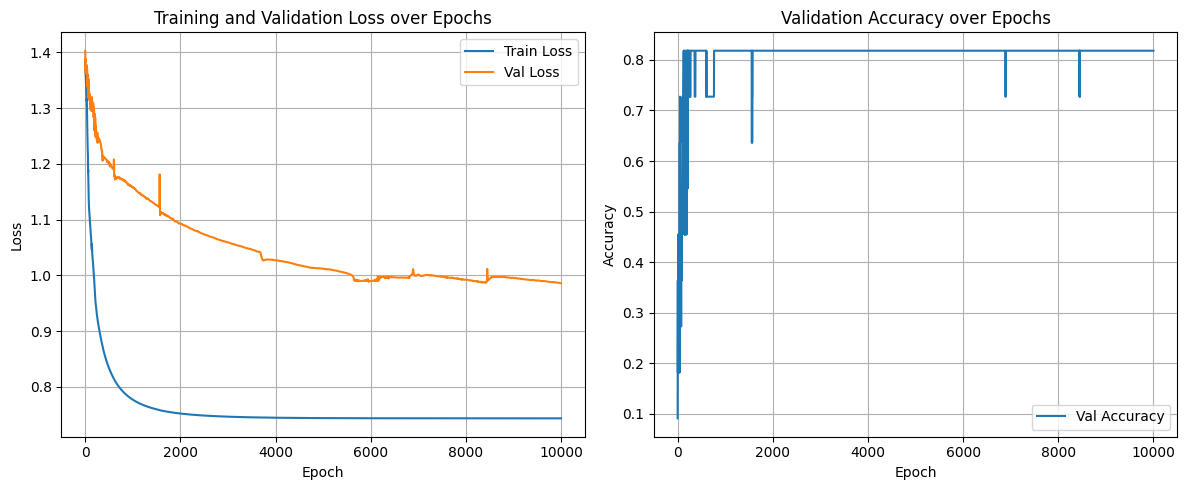

In [ ]:
# Entrenar el modelo
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
import random


# Función para hacer una predicción aleatoria en el conjunto de entrenamiento
def predict_random_sample(model, train_loader):
    model.eval()

    # Seleccionar un lote aleatorio del conjunto de entrenamiento
    random_batch = random.choice(train_loader.dataset)

    # Obtener las entradas y etiquetas del lote
    inputs, label = random_batch

    # Si es necesario, ajustar la forma de las entradas para que se ajuste al modelo
    inputs = inputs.unsqueeze(0)  # Añadir una dimensión de lote

    # Hacer la predicción
    with torch.no_grad():
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

    # Imprimir la etiqueta verdadera y la predicción
    print(f'Etiqueta verdadera: {label.item()}, Predicción: {predicted.item()}')

In [ ]:

predict_random_sample(model, val_loader)

Etiqueta verdadera: 0, Predicción: 0
